In [1]:
import tensorflow as tf
import numpy as np
from functools import partial
from sklearn.preprocessing import StandardScaler

noise_level = 0.5
n_features = 28 * 28
n_outputs = n_features

dnn_layer = partial(tf.layers.dense, activation=tf.nn.elu)

with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, shape=[None, n_features])
    X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

with tf.name_scope('encoder'):
    hidden1 = dnn_layer(X_noisy, 128, name='hidden1')
    hidden2 = dnn_layer(hidden1, 64, name='hidden2')
    hidden3 = dnn_layer(hidden2, 32, name='hidden3')

with tf.name_scope('decoder'):
    hidden4 = dnn_layer(hidden3, 64, name='hidden4')
    hidden5 = dnn_layer(hidden4, 128, name='hidden5')
    outputs = dnn_layer(hidden5, n_outputs, name='outputs')

with tf.name_scope('evaluation'):
    reconstruction_loss = tf.losses.mean_squared_error(X, outputs)

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(reconstruction_loss)

W0908 00:17:16.881471 140341973870400 deprecation.py:323] From <ipython-input-1-2edc32936782>:17: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0908 00:17:16.883589 140341973870400 deprecation.py:506] From /home/guhwanbae/anaconda3/envs/gu-keras/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0908 00:17:17.155603 140341973870400 deprecation.py:323] From /home/guhwanbae/anaconda3/envs/gu-keras/lib/python3.7/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instruc

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train.reshape(len(y_train), -1).astype(np.float32)
X_test = X_test.reshape(len(y_test), -1).astype(np.float32)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [4]:
def random_batch(X, y, batch_size):
    n_samples = len(X)
    n_batches = int(np.ceil(n_samples / batch_size))
    shuffle_idx = np.random.permutation(n_samples)
    for rand_idx in np.array_split(shuffle_idx, n_batches):
        X_batch = X[rand_idx]
        y_batch = y[rand_idx]
        yield X_batch, y_batch

In [5]:
n_epochs = 50
batch_size = 1024
model_path = './gaussian_denoisor_with_dnn.ckpt'

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in random_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print('Epoch={:5d} MSE={:1.5f}'.format(epoch, loss_train))
        saver.save(sess, model_path)

Epoch=    0 MSE=0.66440
Epoch=    1 MSE=0.44422
Epoch=    2 MSE=0.38502
Epoch=    3 MSE=0.39986
Epoch=    4 MSE=0.43173
Epoch=    5 MSE=0.32487
Epoch=    6 MSE=0.36754
Epoch=    7 MSE=0.39203
Epoch=    8 MSE=0.32606
Epoch=    9 MSE=0.34157
Epoch=   10 MSE=0.28663
Epoch=   11 MSE=0.34142
Epoch=   12 MSE=0.37366
Epoch=   13 MSE=0.28388
Epoch=   14 MSE=0.27089
Epoch=   15 MSE=0.29830
Epoch=   16 MSE=0.26200
Epoch=   17 MSE=0.27332
Epoch=   18 MSE=0.32486
Epoch=   19 MSE=0.26110
Epoch=   20 MSE=0.27150
Epoch=   21 MSE=0.26157
Epoch=   22 MSE=0.29339
Epoch=   23 MSE=0.27525
Epoch=   24 MSE=0.25111
Epoch=   25 MSE=0.27623
Epoch=   26 MSE=0.26259
Epoch=   27 MSE=0.27439
Epoch=   28 MSE=0.25221
Epoch=   29 MSE=0.24847
Epoch=   30 MSE=0.25141
Epoch=   31 MSE=0.25134
Epoch=   32 MSE=0.23655
Epoch=   33 MSE=0.24467
Epoch=   34 MSE=0.23045
Epoch=   35 MSE=0.26296
Epoch=   36 MSE=0.24381
Epoch=   37 MSE=0.23640
Epoch=   38 MSE=0.24227
Epoch=   39 MSE=0.25320
Epoch=   40 MSE=0.24065
Epoch=   41 MSE=

In [6]:
with tf.Session() as sess:
    saver.restore(sess, model_path)
    noisy_samples, reconstructions = sess.run([X_noisy, outputs], feed_dict={X: X_test})

W0908 00:17:34.091025 140341973870400 deprecation.py:323] From /home/guhwanbae/anaconda3/envs/gu-keras/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


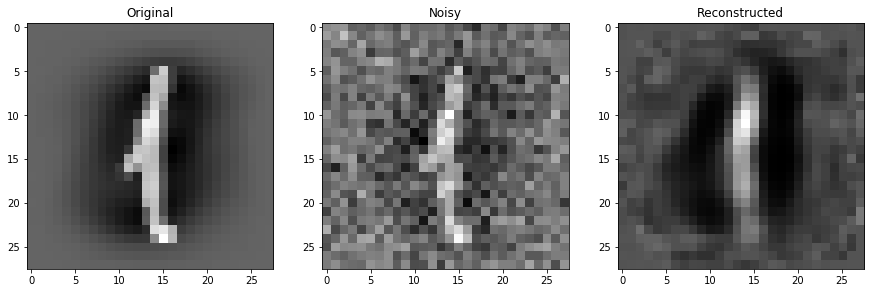

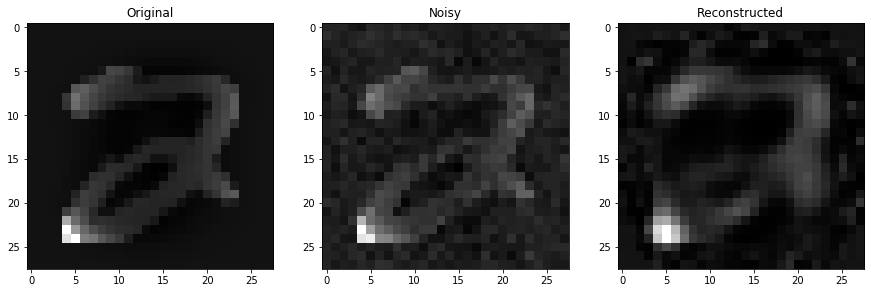

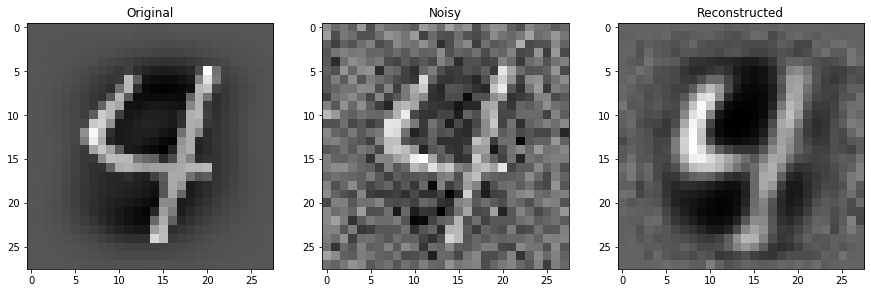

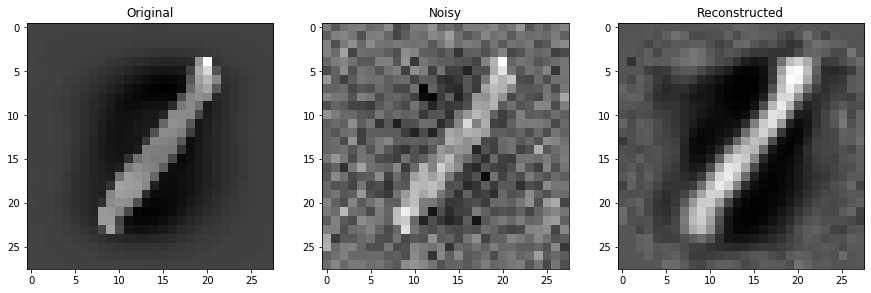

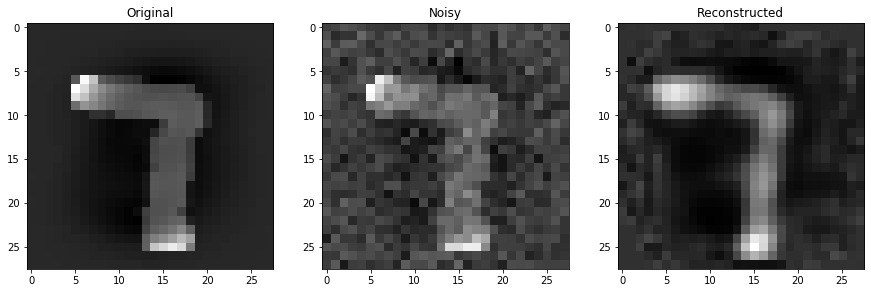

In [8]:
import matplotlib.pyplot as plt

for rand_idx in np.random.randint(0, len(noisy_samples)-1, 5):
    plt.figure(figsize=(15,9))
    plt.gray()
    
    plt.subplot(131)
    plt.title('Original')
    plt.imshow(X_test[rand_idx].reshape(28,28))
    
    plt.subplot(132)
    plt.title('Noisy')
    plt.imshow(noisy_samples[rand_idx].reshape(28,28))
    
    plt.subplot(133)
    plt.title('Reconstructed')
    plt.imshow(reconstructions[rand_idx].reshape(28,28))
    plt.show()